# Project Title: SympToMatch
## Subtitle: Unleashing the power of AI to match patients with the right care


### Goal
The goal of this project is to develop an advanced would classify audio with ailments descriptions into severe and mild, and afterwards matching the ailment with the right medical specialization. The system should be capable of accurately transcribing and understanding spoken queries from callers seeking medical advice or information. The project aims to improve the efficiency and effectiveness of the telenursing service by automating the initial query handling process.


### Approach 
1. __collecting of audio files__ from kaggle (source : https://www.kaggle.com/datasets/paultimothymooney/medical-speech-transcription-and-intent)
2. __transcribing audio into text__
3. __labeling data__ into severe and mild (i.e., 2 classes)
4. __training Model_1__ a supervised ML classification algorithm to discriminte ailments desciptions by severity 
5. __labeling data__ assigning ailments to 12 different medical specializations (i.e., dermatology, gastroenterology, psychology, orthopedy, rheumatology, general, cardiology, ophthalmology, wound care, otorhinolaryngology, emergency - or ER- ,and physiatry)
6. __training Model_2__ a supervised ML classification algorithm to assign ailments in 12 classes
7. __testing Model_1 and Model_2 on unseen data__ to evaluate the performance of the models


In [1]:
# Installing dependencies

## Converting audio to text
# pip install SpeechRecognition
# pip install tqdm

## Extracting features from audio
# pip install pydub

# Classification
# pip install cleantext

# Visualization
# pip install pySankey

In [1]:
# Converting audio to text
import speech_recognition as sr
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.font_manager
from pySankey.sankey import sankey

# Regex
import re

# NLTK resources
import nltk
from nltk.tag import pos_tag
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Word frequency for classification
from nltk.corpus import stopwords
from collections import Counter

# Stemming words
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from functools import reduce

# Converting string to dictionary
import ast

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Supervised machine learning classification
from cleantext import clean

# Baseline
from sklearn.dummy import DummyClassifier

# Building model 1
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Buildind model 2
from scipy.stats import randint
from io import StringIO
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Loading metrics to evaluate models
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, RocCurveDisplay

# Extracting features from audio files
from pydub import AudioSegment
import librosa
import librosa.display

# Deployment
from joblib import dump


[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# List of functions 

def get_file_name(path):
    """Extract file name from path. The input is a string."""
    pattern = r"/([^/]+)$" 
    match = re.search(pattern, path)
    if match:
        file_name = match.group(1)
        return file_name
    else:
        return None
    
def do_clean(text):
    """The string (text) is converted to lowercase, it is stripped, and the punctualization is removed."""
    return clean(text, lowercase=True, extra_spaces=False, punct=True)


def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)


# preprocess the text by removing stopwords and filtering out nouns
def preprocess_text(text):
    stopwords_set = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    nouns = [word for word, tag in pos_tags if tag.startswith('NN') and word.lower() not in stopwords_set]
    return nouns


# Fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))


# Call it when testing a new sentence
def find(x):
    if x == 1:
        print ("Severe")
    else:
        print ("Mild")
        
        
# Stemming words 
def stemmer(sentence):
    ps = PorterStemmer()
    words = word_tokenize(sentence)
    # using reduce to apply stemmer to each word and join them back into a string
    stemmed_sentence = reduce(lambda x, y: x + " " + ps.stem(y), words, "")
    return stemmed_sentence

In [3]:
# Settings for visualizations
# Color palette for all figures (following 1177 color palette)
dark = "#318ccdff" #blue
light= "#e65a67ff" #red

# Font dictionary
font1 = {'family':'Helvetica','color':'black','size':20, 'weight' :"bold"}
font2 = {'family':'Helvetica','color':'black','size':14, 'weight' :"bold"}

# STEP 1
### Collecting audio files from kaggle.

The folder downloaded from Kaggle contains 3 subfolders, named "test", "train" and "validate", with respectively 5895, 381 and 385 wav files. In ecah folder the audio files are unique, however the sentence is repeted, reducing drastically the sample size. Therefore, only the files belonging to the "test" folder are used.

__Tools__: 
- SpeechRecognition library, which supports several speech recognition engines, including Google Speech Recognition
- recognize_google (https://github.com/Uberi/speech_recognition/blob/master/reference/library-reference.rst)
- tqdm (to estimate progress)


### Processing audio files

In [271]:
# Set home directory
dir_path = "/Users/admin/Downloads/archive (3)/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test/"
# List of all files in directory
audio_files = os.listdir(dir_path)

# Create a recognizer object
r = sr.Recognizer()

# Create empty lists to store text and filename
text_list = []
filename_list = []

# Process each audio file
for audio_file in tqdm(audio_files, desc="Processing"):
    try:
        audio_path = os.path.join(dir_path, audio_file)

        # Open the audio file
        with sr.AudioFile(audio_path) as source:
            # Read the audio data
            audio_data = r.record(source)

        # Convert speech to text
        text = r.recognize_google(audio_data, show_all=True)

        # Append text and filename to lists
        text_list.append(text)
        filename_list.append(audio_file)
    
    # To handle exeptions, such as empty files
    except sr.RequestError as e:
        print(f"Error processing audio file: {audio_file} - {e}")
        continue
    
    except sr.UnknownValueError:
        print(f"No speech detected in audio file: {audio_file}")
        continue


Processing:   0%|                            | 1/5895 [00:02<3:59:11,  2.43s/it]


KeyboardInterrupt: 

In [4]:
# Create DataFrame
data = {"Text": text_list, "Filename": filename_list}
df_test = pd.DataFrame(data)
df_test.to_csv("df_test_data.csv", index=False)

NameError: name 'text_list' is not defined

In [5]:
# To load the DataFrame without creating from scratch
df_test = pd.read_csv("data/df_test_data.csv")

In [6]:
df_test.head()

,Text,Filename
0,{'alternative': [{'transcript': 'I had a pain ...,1249120_30766630_68687326.wav
1,"{'alternative': [{'transcript': ""I can't carry...",1249120_43620482_83629897.wav
2,{'alternative': [{'transcript': 'I got this st...,1249120_43758322_46768180.wav
3,{'alternative': [{'transcript': 'I have a stro...,1249120_43612961_52251557.wav
4,{'alternative': [{'transcript': 'my hair alway...,1249120_41087148_36008493.wav


In [7]:
# The `test` contained 5895 files, but the dataframes has 5725 rows, indicating that 170 audios files were compromised.
df_test.shape # 5725, 2  ---> excluded 170 audios files 

(5725, 2)

In [8]:
# Example of  transcripts from the audio file '1249120_30766630_68687326.wav'
df_test.Text[0]

"{'alternative': [{'transcript': 'I had a pain in my knee when I was swimming', 'confidence': 0.97433341}, {'transcript': 'I hod a pain in my knee when I was swimming', 'confidence': 0.97433341}, {'transcript': 'igh had a pain in my knee when I was swimming', 'confidence': 0.97433341}, {'transcript': 'I had a pain in my knee wwhen I was swimming', 'confidence': 0.97433341}, {'transcript': 'I had a pain in my knee when igh was swimming', 'confidence': 0.97433341}], 'final': True}"

# Step 2
### Transcribing audio into text

In [9]:
# Clean Text column (keep 'transcript' and  'confidence' value) 

text_clean_lst = []
confidence_level_lst=[]

for i in range(len(df_test)):

    text = df_test.Text[i]
    if len(text) == 2:
        text_clean_lst.append(None)
        confidence_level_lst.append(None)
    else:
        try: 
            input_dict = ast.literal_eval(text)
            text_clean = input_dict['alternative'][0]['transcript']
            text_clean_lst.append(text_clean)


            confidence_level = input_dict['alternative'][0]['confidence']
            confidence_level_lst.append(confidence_level)

        except (ValueError, KeyError):
            continue

In [10]:
# Merge the text_clean_lst and confidence_level_lst lists as new column of the DataFrame
df_test['text_clean'] = text_clean_lst
df_test['confidence'] = confidence_level_lst

In [11]:
df_test.head()

,Text,Filename,text_clean,confidence
0,{'alternative': [{'transcript': 'I had a pain ...,1249120_30766630_68687326.wav,I had a pain in my knee when I was swimming,0.974333
1,"{'alternative': [{'transcript': ""I can't carry...",1249120_43620482_83629897.wav,I can't carry anything I have a pain in my sho...,0.962365
2,{'alternative': [{'transcript': 'I got this st...,1249120_43758322_46768180.wav,I got this strange rash on my arm,0.526928
3,{'alternative': [{'transcript': 'I have a stro...,1249120_43612961_52251557.wav,I have a strong shoulder pain,0.987629
4,{'alternative': [{'transcript': 'my hair alway...,1249120_41087148_36008493.wav,my hair always falls out and I have lost a lot...,0.842741


In [12]:
# Drop the 'Text' columns
df_test.drop(columns=['Text'], inplace = True)

In [13]:
df_test.head()

,Filename,text_clean,confidence
0,1249120_30766630_68687326.wav,I had a pain in my knee when I was swimming,0.974333
1,1249120_43620482_83629897.wav,I can't carry anything I have a pain in my sho...,0.962365
2,1249120_43758322_46768180.wav,I got this strange rash on my arm,0.526928
3,1249120_43612961_52251557.wav,I have a strong shoulder pain,0.987629
4,1249120_41087148_36008493.wav,my hair always falls out and I have lost a lot...,0.842741


# Step 3
### Labeling data for Model 1
Make a phrase-severity dictionary

In [14]:
# Read a file with manually annotated sentences as 1 (severe) or 0 (mild)
phrase_severity = pd.read_csv("data/phrase_severity.csv")
phrase_severity.drop_duplicates(subset=['phrase'], keep='first', inplace = True)

In [15]:
phrase_severity.head()

,severity,same_phrase,phrase
0,0,A,A terrible fall in hair
9,0,A,After a breakup I feel something strange in me.
21,0,A,After an hard working day I have foot ache
29,1,B,After eating I have burning sensation inside ...
41,0,A,"after playing football, i have muscle pain wit..."


In [16]:
# Merge the file 
overview = pd.read_csv("data/overview-of-recordings.csv")

In [17]:
phrase_severity = overview.merge(phrase_severity, how='inner', left_on='phrase', right_on='phrase')

# count Na
# 8 Na --> drop
phrase_severity.isna().sum
phrase_severity.dropna(inplace = True)

phrase_severity.drop(columns=['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'writer_id', 'same_phrase' ], inplace = True)

In [18]:
phrase_severity.head()

,file_name,phrase,prompt,severity
0,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,0
1,1249120_44101988_15603242.wav,When I remember her I feel down,Emotional pain,0
2,1249120_42557795_23962229.wav,When I remember her I feel down,Emotional pain,0
3,1249120_43350908_87872469.wav,When I remember her I feel down,Emotional pain,0
4,1249120_43577102_60151953.wav,When I remember her I feel down,Emotional pain,0


In [19]:
phrase_severity.columns = ['file_name', 'phrase_orig', 'prompt', 'severity']
phrase_severity.columns

Index(['file_name', 'phrase_orig', 'prompt', 'severity'], dtype='object')

In [20]:
df_test.columns

Index(['Filename', 'text_clean', 'confidence'], dtype='object')

In [21]:
## Merge ph_severity with df_test by 'file_name'
df_test = df_test.merge(phrase_severity, how='inner', left_on='Filename', right_on='file_name')

In [22]:
df_test.head()

,Filename,text_clean,confidence,file_name,phrase_orig,prompt,severity
0,1249120_30766630_68687326.wav,I had a pain in my knee when I was swimming,0.974333,1249120_30766630_68687326.wav,I had a pain in my knee when I was swimming,Knee pain,1
1,1249120_43620482_83629897.wav,I can't carry anything I have a pain in my sho...,0.962365,1249120_43620482_83629897.wav,I can't carry anything I have a pain in my sho...,Shoulder pain,1
2,1249120_43758322_46768180.wav,I got this strange rash on my arm,0.526928,1249120_43758322_46768180.wav,I have this strange rash on my arm.,Skin issue,1
3,1249120_43612961_52251557.wav,I have a strong shoulder pain,0.987629,1249120_43612961_52251557.wav,i have a strong shoulder pain,Shoulder pain,1
4,1249120_41087148_36008493.wav,my hair always falls out and I have lost a lot...,0.842741,1249120_41087148_36008493.wav,My hair always falls out and i have lost a lot...,Hair falling out,1


In [23]:
df_test.drop(columns=['Filename'], inplace = True)

In [24]:
# check for Nas (n=184)
df_test.isna().sum()
df_test.dropna(inplace = True)

In [25]:
# Convert 'text_clean' and 'phrase_orig' to lower case and strip the text
df_test['text_clean'] = df_test['text_clean'].apply(do_clean)
df_test['phrase_orig'] = df_test['phrase_orig'].apply(do_clean)

In [26]:
df_test.head()

,text_clean,confidence,file_name,phrase_orig,prompt,severity
0,i had a pain in my knee when i was swimming,0.974333,1249120_30766630_68687326.wav,i had a pain in my knee when i was swimming,Knee pain,1
1,i cant carry anything i have a pain in my shou...,0.962365,1249120_43620482_83629897.wav,i cant carry anything i have a pain in my shou...,Shoulder pain,1
2,i got this strange rash on my arm,0.526928,1249120_43758322_46768180.wav,i have this strange rash on my arm,Skin issue,1
3,i have a strong shoulder pain,0.987629,1249120_43612961_52251557.wav,i have a strong shoulder pain,Shoulder pain,1
4,my hair always falls out and i have lost a lot...,0.842741,1249120_41087148_36008493.wav,my hair always falls out and i have lost a lot...,Hair falling out,1


In [27]:
# Keep only the row with the highest value in 'confidence' for each unique value in 'phrase_orig'
df_max = df_test.groupby('phrase_orig')['confidence'].idxmax()
df_test = df_test.loc[df_max]

In [28]:
df_test.head() # (695, 7)

,text_clean,confidence,file_name,phrase_orig,prompt,severity
4667,a terrible fall in hair,0.990103,1249120_43577102_62787251.wav,a terrible fall in hair,Hair falling out,0
340,after a breakup i feel something strange in me,0.830414,1249120_44093933_109330064.wav,after a breakup i feel something strange in me,Emotional pain,0
3786,oculuspartner,0.846174,1249120_42210938_72512880.wav,after an hard working day i have foot ache,Foot ache,0
160,after eating i have burning sensation inside o...,0.987629,1249120_43856216_87143624.wav,after eating i have burning sensation inside ...,Stomach ache,1
2902,after playing football i have muscle pain with...,0.995087,1249120_41841195_57027955.wav,after playing football i have muscle pain with...,Muscle pain,0


In [29]:
df_test.reset_index(inplace = True, drop = True)

In [30]:
df_test.drop(columns=['phrase_orig'], inplace = True)

In [31]:
df_test.head()

,text_clean,confidence,file_name,prompt,severity
0,a terrible fall in hair,0.990103,1249120_43577102_62787251.wav,Hair falling out,0
1,after a breakup i feel something strange in me,0.830414,1249120_44093933_109330064.wav,Emotional pain,0
2,oculuspartner,0.846174,1249120_42210938_72512880.wav,Foot ache,0
3,after eating i have burning sensation inside o...,0.987629,1249120_43856216_87143624.wav,Stomach ache,1
4,after playing football i have muscle pain with...,0.995087,1249120_41841195_57027955.wav,Muscle pain,0


### Exploratory analysis

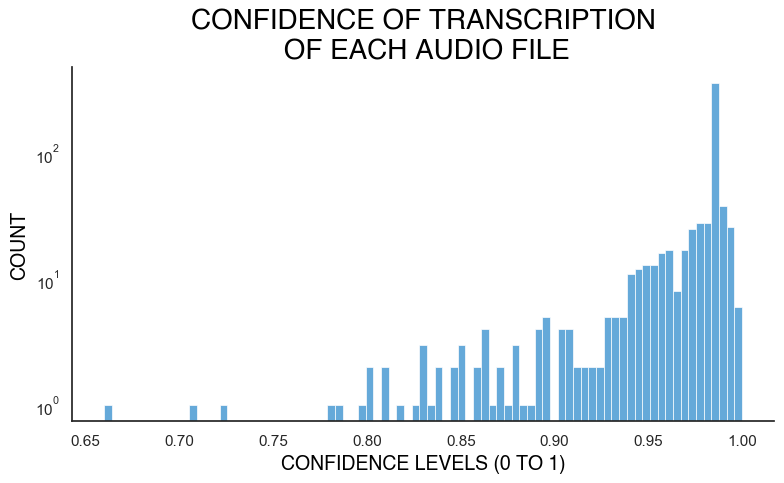

In [32]:
# Set figure size and style
plt.figure(figsize=(8, 5))
sns.set(style="white")

# Plot histogram with KDE
sns.histplot(data=df_test, x='confidence', color="#318ccdff")

# Set plot title and labels
plt.title("CONFIDENCE OF TRANSCRIPTION\n OF EACH AUDIO FILE", fontdict=font1)
plt.xlabel("CONFIDENCE LEVELS (0 TO 1)", fontdict=font2)
plt.ylabel("COUNT", fontdict=font2)

# Remove top and right spines
sns.despine()

# Set y-axis to logarithmic scale
plt.yscale("log")

# Adjust plot layout for better readability
plt.tight_layout()

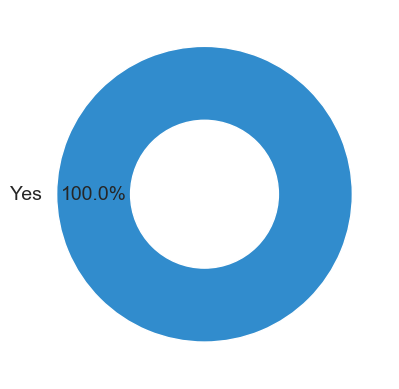

In [33]:
# Donut plot: how many audios are excluded because of bad quality?

df_test['keep'] = np.where(df_test['confidence'] <= 0.5, 'No', 'Yes')

label = list(pd.Series(df_test['keep']).value_counts().index)
count = list(pd.Series(df_test['keep']).value_counts().values)

colors = [dark, light]
#explode = (0.05, 0.05)
plt.pie(count, colors=colors, labels=label,
        autopct='%1.1f%%', pctdistance=0.75, textprops={'fontsize': 14})
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

In [34]:
### Features about the audio

# Load files
dir_path = "/Users/admin/Downloads/archive (3)/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test/" 
audio_files = os.listdir(dir_path)

audio_duration_lst = []
audio_intesnsity_lst = []

for n in range(len(audio_files)):
    audio = dir_path+audio_files[n]
    audio_segment = AudioSegment.from_file(audio)
    audio_duration_lst.append(len(audio_segment))
    audio_intesnsity_lst.append(audio_segment.dBFS)


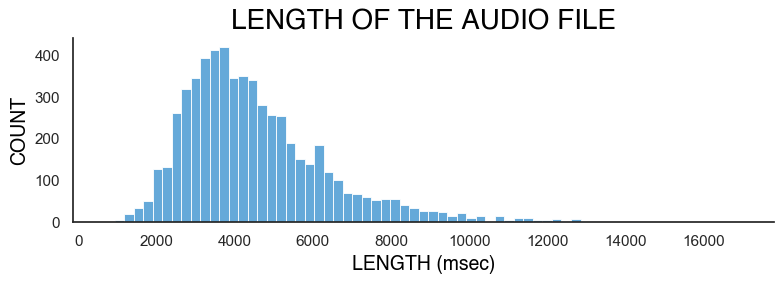

In [35]:
# Set figure style
sns.set(style="white")

# Set figure size and style
plt.figure(figsize=(8, 3))
sns.set(style="white")

# Plot histogram with KDE
sns.histplot(audio_duration_lst,  color="#318ccdff")

# Set plot title and labels
plt.title("LENGTH OF THE AUDIO FILE", fontdict=font1)
plt.xlabel("LENGTH (msec)", fontdict=font2)
plt.ylabel("COUNT", fontdict=font2)

# Remove top and right spines
sns.despine()

# Adjust plot layout for better readability
plt.tight_layout()


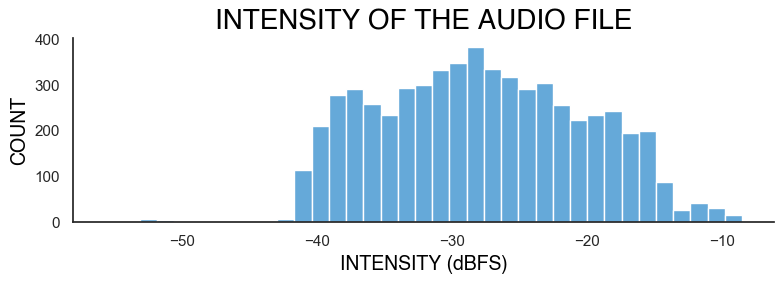

In [36]:
# Set figure style
sns.set(style="white")

# Set figure size and style
plt.figure(figsize=(8, 3))
sns.set(style="white")

# Plot histogram with KDE
sns.histplot(audio_intesnsity_lst, color="#318ccdff")

# Set plot title and labels
plt.title("INTENSITY OF THE AUDIO FILE", fontdict=font1)
plt.xlabel("INTENSITY (dBFS)", fontdict=font2)
plt.ylabel("COUNT", fontdict=font2)

# Remove top and right spines
sns.despine()

# Adjust plot layout for better readability
plt.tight_layout()


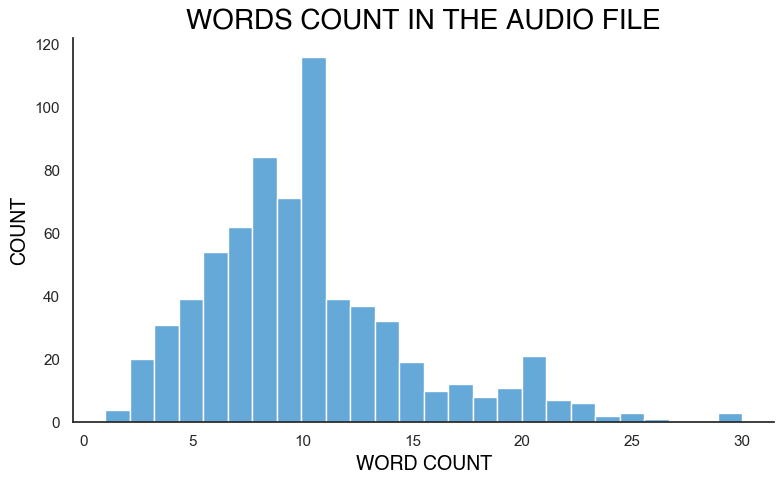

In [37]:
### Features about the text

# Set figure size and style
plt.figure(figsize=(8, 5))
sns.set(style="white")

# words count
df_test['word_count'] = df_test['text_clean'].apply(lambda x: len(str(x).split()))
sns.histplot(df_test, x='word_count', color = dark)

# Set plot title and labels
plt.title("WORDS COUNT IN THE AUDIO FILE", fontdict=font1)
plt.xlabel("WORD COUNT", fontdict=font2)
plt.ylabel("COUNT", fontdict=font2)

# Adjust plot layout for better readability
plt.tight_layout()

# Remove top and right spines
sns.despine()


# Step 4
### Model_1: supervised machine learning to classify severe vs mild ailments

In [38]:
# Drop if word_count <= 3
df_test = df_test[df_test['word_count']>3]

In [39]:
df_test.head()

,text_clean,confidence,file_name,prompt,severity,keep,word_count
0,a terrible fall in hair,0.990103,1249120_43577102_62787251.wav,Hair falling out,0,Yes,5
1,after a breakup i feel something strange in me,0.830414,1249120_44093933_109330064.wav,Emotional pain,0,Yes,9
3,after eating i have burning sensation inside o...,0.987629,1249120_43856216_87143624.wav,Stomach ache,1,Yes,9
4,after playing football i have muscle pain with...,0.995087,1249120_41841195_57027955.wav,Muscle pain,0,Yes,11
5,after playing tennis i had a powerful sensatio...,0.988203,1249120_33905644_36396763.wav,Shoulder pain,0,Yes,12


In [40]:
## Clean dataset
df_test['text_clean_extra_clean'] = df_test['text_clean'].apply(do_clean)

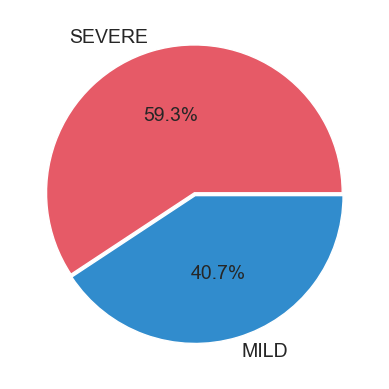

In [41]:
sev_class = pd.Series(df_test.severity).value_counts()
sev_class.index  # [1.0, 0.0]
sev_class.values # [397, 274]

label = ['SEVERE', 'MILD']
count = sev_class.values

colors = [light, dark]
explode = (0.01, 0.01)
plt.pie(count, colors=colors, labels=label,
        autopct='%1.1f%%', pctdistance=0.55, textprops={'fontsize': 14}, explode=explode)
plt.show()

In [42]:
# Generate more labeled phrases using ChatGTP
df_chatGTP = pd.read_csv("data/chatGTP.csv")

In [43]:
df_chatGTP.head()

,text,severity,prompt
0,I have a severe sore throat and can't swallow.,1,Otorhinolaryngology
1,"I noticed a large, painful lump on my neck.",1,General
2,I have been experiencing intense chest pain.,1,Cardiology
3,My child has been complaining of severe abdomi...,1,Gastroenterology
4,I have been feeling extremely fatigued and weak.,0,General


#### Convert text and promp to lowercase
df_chatGTP['prompt'] = df_chatGTP['prompt'].str.lower()
df_chatGTP['text'] = df_chatGTP['text'].str.lower()

df_chatGTP.columns = ['text_clean', 'severity','prompt']

In [44]:
# Convert text and promp to lowercase
df_chatGTP['prompt'] = df_chatGTP['prompt'].apply(do_clean)
df_chatGTP['text'] = df_chatGTP['text'].apply(do_clean)

df_chatGTP.columns = ['text_clean', 'severity','prompt']

In [45]:
df_chatGTP.head()

,text_clean,severity,prompt
0,i have a severe sore throat and cant swallow,1,otorhinolaryngology
1,i noticed a large painful lump on my neck,1,general
2,i have been experiencing intense chest pain,1,cardiology
3,my child has been complaining of severe abdomi...,1,gastroenterology
4,i have been feeling extremely fatigued and weak,0,general


In [46]:
df_test1 = df_test[['text_clean', 'severity','prompt']].copy()
# Concatenate df_test and df_chatGPT
df_test1 = pd.concat([df_test1, df_chatGTP], ignore_index= True)

In [47]:
df_test1.isna().sum()

text_clean    0
severity      0
prompt        0
dtype: int64

In [48]:
# Create a new dataframe with two columns
df_test1 = df_test1[['severity', 'text_clean']].copy()
df_test1.head()

,severity,text_clean
0,0,a terrible fall in hair
1,0,after a breakup i feel something strange in me
2,1,after eating i have burning sensation inside o...
3,0,after playing football i have muscle pain with...
4,0,after playing tennis i had a powerful sensatio...


In [49]:
# Remove stopwords and punctuation
df_test1['text_clean'] = df_test1['text_clean'].apply(text_process)
df_test1.head()

,severity,text_clean
0,0,terrible fall hair
1,0,breakup feel something strange
2,1,eating burning sensation inside
3,0,playing football muscle pain legs
4,0,playing tennis powerful sensation close neck


In [50]:
# Stemming words 
df_test1['text_clean'] = df_test1['text_clean'].apply(stemmer)
df_test1.head()


,severity,text_clean
0,0,terribl fall hair
1,0,breakup feel someth strang
2,1,eat burn sensat insid
3,0,play footbal muscl pain leg
4,0,play tenni power sensat close neck


In [51]:
# Create a new column 'category_id' with encoded categories 
df_test1 = df_test1[['severity', 'text_clean']].copy()

df_test1['category_id'] = df_test1['severity'].factorize()[0]
category_id_df = df_test1[['severity', 'category_id']].drop_duplicates()

In [52]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'severity']].values)

# New dataframe
df_test1.head()

,severity,text_clean,category_id
0,0,terribl fall hair,0
1,0,breakup feel someth strang,0
2,1,eat burn sensat insid,1
3,0,play footbal muscl pain leg,0
4,0,play tenni power sensat close neck,0


In [53]:
# The text needs to be transformed to vectors so as the algorithms will be able make predictions.

#  Convert the text data into vectors (TfidfVectorizer)
#  Feature engineering: TF-IDF Vectors as features

## The importance increases proportionally to the number of times a word appears in the review but is 
## offset by the frequency of the word in the entire review corpus.

## TF or Term Frequency measures how frequently a term appears in a document
## IDF or Inverse Document Frequency measures the importance of each term

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# Transform each ailment into a vector
features = tfidf.fit_transform(df_test1.text_clean).toarray()

labels = df_test1.category_id

print("Each of the %d sentences is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1240 sentences is represented by 359 features (TF-IDF score of unigrams and bigrams)


In [54]:
labels.value_counts()

category_id
1    672
0    568
Name: count, dtype: int64

In [55]:
# Splitting the data into train and test sets
X = df_test1['text_clean'] # Collection of ailments
y = df_test1['severity'] # Target or the labels we want to predict (i.e., mild vs severe)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [56]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_test1.index, test_size=0.25, random_state = 0)

### Set Baseline for MODEL 1

In [57]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_true = y_test.copy()
y_pred = dummy.predict(X_test)
baseline = accuracy_score(y_true, y_pred)
print(f"The baseline to beat is: {baseline}")

The baseline to beat is: 0.5774193548387097


In [58]:
# Models for accuracy
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=49),
    DecisionTreeClassifier(min_samples_split=7, random_state=111)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='recall', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'recall'])

In [59]:
cv_df.groupby('model_name').recall.mean()

model_name
DecisionTreeClassifier    0.740157
KNeighborsClassifier      0.823500
LinearSVC                 0.811338
LogisticRegression        0.833581
MultinomialNB             0.853803
RandomForestClassifier    0.963451
Name: recall, dtype: float64

In [60]:
mean_recall = cv_df.groupby('model_name').recall.mean()
std_recall = cv_df.groupby('model_name').recall.std()

acc = pd.concat([mean_recall, std_recall], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean recall', 'Standard deviation']
acc

,Mean recall,Standard deviation
model_name,,
DecisionTreeClassifier,0.740157,0.051424
KNeighborsClassifier,0.823500,0.020000
LinearSVC,0.811338,0.045793
LogisticRegression,0.833581,0.046195
MultinomialNB,0.853803,0.042821
RandomForestClassifier,0.963451,0.015534


In [61]:
cv_df['col']=np.where(cv_df['model_name']=='RandomForestClassifier', 'red', 'blue')
cv_df['model_name']=cv_df['model_name'].map({'RandomForestClassifier': 'rForest',
                                            'LinearSVC':'linSVC',
                                            'MultinomialNB': 'MulNB',
                                            'LogisticRegression':'LogRex',
                                            'KNeighborsClassifier':'KNC',
                                            'DecisionTreeClassifier':'DecTree'})

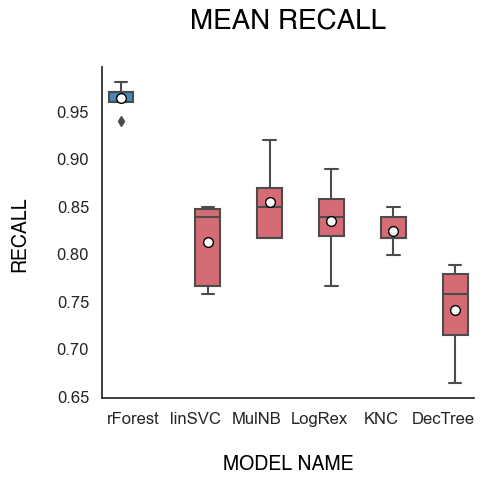

In [62]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='model_name', y='recall', 
            data=cv_df, 
            palette=[dark, light], 
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"7"},
            hue = 'col')
plt.title("MEAN RECALL\n",  fontdict= font1)
plt.xlabel("\nMODEL NAME",  fontdict= font2)
plt.ylabel("RECALL\n",  fontdict= font2)
plt.legend([], [], frameon=False, )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines
sns.despine()

# Adjust plot layout for better readability
plt.tight_layout()

# plt.savefig("boxplot_Model1.png", transparent = True)
# plt.show()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_test1.index, test_size=0.25, 
                                                               random_state=1)

In [63]:
# Train
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f"Recall score: {recall_score(y_train, y_pred)}")

Recall score: 0.9188640973630832


In [64]:
print(f"Precision score: {precision_score(y_train, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_train, y_pred)}")

Precision score: 0.8357933579335793
Accuracy score: 0.8612903225806452


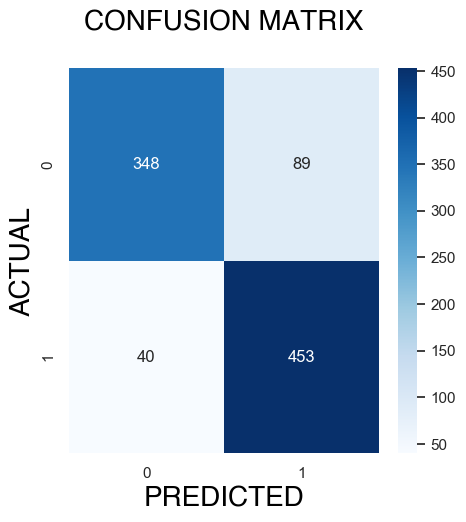

In [65]:
# Confusion matrix train
conf_mat = confusion_matrix(y_train, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.severity.values, 
            yticklabels=category_id_df.severity.values)
plt.ylabel('ACTUAL', fontdict=font1)
plt.xlabel('PREDICTED', fontdict=font1)
plt.title("CONFUSION MATRIX\n", fontdict=font1)
plt.savefig("cm_model1_mnb.png", transparent = True)

In [66]:
# Test
model__1 = MultinomialNB()
model__1.fit(X_test, y_test)
y_pred = model__1.predict(X_test)
print(f"Recall score: {recall_score(y_test, y_pred)}")

Recall score: 0.9664804469273743


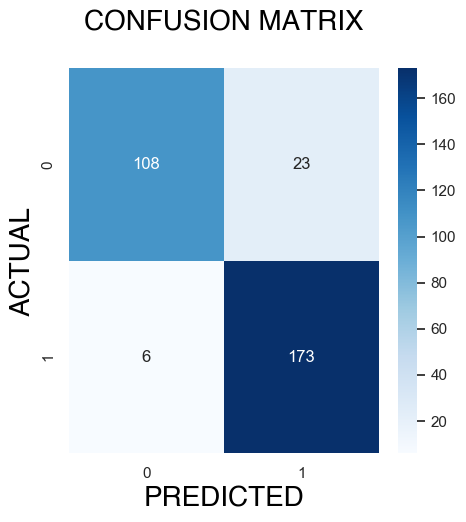

In [67]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.severity.values, 
            yticklabels=category_id_df.severity.values)
plt.ylabel('ACTUAL', fontdict=font1)
plt.xlabel('PREDICTED', fontdict=font1)
plt.title("CONFUSION MATRIX\n", fontdict=font1)
plt.savefig("cm_model1_mnb.png", transparent = True)

In [68]:
# Misclassification
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(df_test1.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['severity', 
                                                                'text_clean']])
            print('')

'1' predicted as '0' : 6 examples.


,severity,text_clean
18,1,even though adult face keep break pimpl
39,1,im alway cold even im wear layer
303,1,gener discomfort
247,1,headach almost everyday
503,1,knee feel weak gave away day top stair luckil...
204,1,get tire fast bare put cloth morn



'0' predicted as '1' : 23 examples.


,severity,text_clean
194,0,feel heart hurt run long distanc
610,0,there pain foot
709,0,accident burn hand hot oil
406,0,hurt rais arm
569,0,stand less 5 minut bag start wag
254,0,pain elbow joint
108,0,feel pain neck
526,0,right shoulder click move arm
342,0,may overdon
156,0,feel pain bodi


In [69]:
print(f"Precision score: {precision_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Recall score: {recall_score(y_test, y_pred)}")

Precision score: 0.8826530612244898
Accuracy score: 0.9064516129032258
Recall score: 0.9664804469273743


In [71]:
### Test Model 1 on never seen before sentence!

fitted_vectorizer = tfidf.fit(X)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X)

model = MultinomialNB().fit(tfidf_vectorizer_vectors, y)

text_input = stemmer(text_process(do_clean("When I play football I fell muscle pain in the right leg.")))
print(model.predict(fitted_vectorizer.transform([text_input])))

if model.predict(fitted_vectorizer.transform([text_input])) == [0]:
    print("mild")
elif model.predict(fitted_vectorizer.transform([text_input])) == [1]:
    print("severe")
else:
    print("error")

In [79]:
# Save model_1 in a pipeline and export it with pickle

import pickle
from sklearn.pipeline import Pipeline
tf_vect = TfidfVectorizer()
clf = MultinomialNB()
pipe = Pipeline([("vectorizer", tf_vect), ("classifier", clf)])
pipe.fit(X, y)


with open('model_1', 'wb') as picklefile:
    pickle.dump(pipe, picklefile)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

# Step 5
### Model_2: supervised machine learning to classify 12 medical specialties

In [115]:
df_test2 = df_test[['text_clean', 'severity','prompt']].copy()

In [116]:
# replace exsisting prompts with doctor domains
df_test2['prompt'] = df_test2['prompt'].map({'Infected wound':'wound care', 
                                                   'Back pain':'physiatry', 
                                                   'Blurry vision':'ophthalmology', 
                                                   'Ear ache':'otorhinolaryngology',
                                                   'Body feels weak':'general', 
                                                   'Stomach ache':'gastroenterology', 
                                                   'Foot ache':'orthopedy', 
                                                   'Hard to breath':'ER',
                                                   'Emotional pain':'psychology', 
                                                   'Shoulder pain':'orthopedy', 
                                                   'Feeling dizzy':'general', 
                                                   'Acne':'dermatology',
                                                   'Feeling cold':'general', 
                                                   'Head ache':'general', 
                                                   'Muscle pain':'orthopedy', 
                                                   'Neck pain':'orthopedy',
                                                   'Heart hurts':'cardiology', 
                                                   'Injury from sports':'orthopedy', 
                                                   'Internal pain':'general',
                                                   'Hair falling out':'dermatology', 
                                                   'Cough':'general', 
                                                   'Joint pain':'rheumatology', 
                                                   'Knee pain':'orthopedy',
                                                   'Open wound':'wound care', 
                                                   'Skin issue':'dermatology'})

In [117]:
df_test2['prompt'] = df_test2['prompt'].str.lower()

In [118]:
df_test2.isna().sum()

text_clean    0
severity      0
prompt        0
dtype: int64

In [119]:
# Concatenate df_test and df_chatGPT
df_test2 = pd.concat([df_test2, df_chatGTP], ignore_index= True)

In [120]:
df_test2.at[178, 'prompt'] = 'orthopedy'

In [121]:
df_test2.head()

,text_clean,severity,prompt
0,a terrible fall in hair,0,dermatology
1,after a breakup i feel something strange in me,0,psychology
2,after eating i have burning sensation inside o...,1,gastroenterology
3,after playing football i have muscle pain with...,0,orthopedy
4,after playing tennis i had a powerful sensatio...,0,orthopedy


In [122]:
# Create a sample DataFrame with ailment data
data = df_test2.copy()

data = data.groupby(['severity', 'prompt'])['prompt'].count().unstack().T
data.reset_index(inplace = True)
data.head()


df = {
    'prompt': list(data['prompt']),
    '0.0': list(data[0.0]),
    '1.0': list(data[1.0])
}

df = pd.DataFrame(data)

df = df.melt(id_vars='prompt', var_name='severity', value_name='n')
df['severity'] = df['severity'].astype(float)

df['severity']=df['severity'].map({0.:'mild', 1.:'severe'})
df.head()

,prompt,severity,n
0,cardiology,mild,24
1,dermatology,mild,79
2,er,mild,4
3,gastroenterology,mild,49
4,general,mild,99


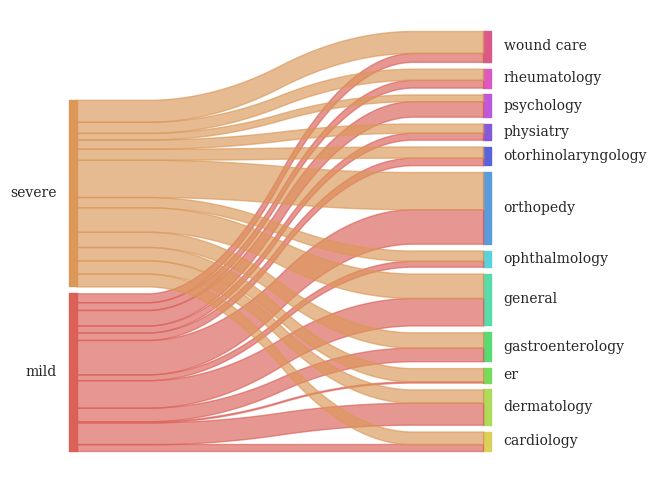

In [123]:
# Import the sankey function from the sankey module within pySankey

colors = {
    'dermatology': '#ffcc00',
    'psychology': '#00cc66',
    'gastroenterology': '#ff6666',
    'orthopedy': '#0099ff',
    'rheumatology': '#9933ff',
    'general': '#ff99cc',
    'cardiology': '#66ccff',
    'ophthalmology': '#ff6699',
    'wound Care': '#ccccff',
    'otorhinolaryngology': '#00ffcc',
    'er': '#ff9933',
    'physiatry': '#99ff33',
    'mild':'#318ccdff', 'severe':'#e65a67ff'
}

sankey(
    left=df["severity"], right=df["prompt"], 
    leftWeight= df["n"], rightWeight=df["n"], 
    aspect=20, fontsize=10
)

plt.savefig("sankey_plot.png", transparent = True)
plt.show()


In [124]:
# Remove stopwords and punctuation
df_test2['text_clean'] = df_test2['text_clean'].apply(text_process)
df_test2.head()

,text_clean,severity,prompt
0,terrible fall hair,0,dermatology
1,breakup feel something strange,0,psychology
2,eating burning sensation inside,1,gastroenterology
3,playing football muscle pain legs,0,orthopedy
4,playing tennis powerful sensation close neck,0,orthopedy


In [125]:
df_test2['text_clean'][:5]

0                              terrible fall hair
1                  breakup feel something strange
2                 eating burning sensation inside
3               playing football muscle pain legs
4    playing tennis powerful sensation close neck
Name: text_clean, dtype: object

In [126]:
# Stemming words 
df_test2['text_clean'] = df_test2['text_clean'].apply(stemmer)
df_test2.head()


,text_clean,severity,prompt
0,terribl fall hair,0,dermatology
1,breakup feel someth strang,0,psychology
2,eat burn sensat insid,1,gastroenterology
3,play footbal muscl pain leg,0,orthopedy
4,play tenni power sensat close neck,0,orthopedy


In [127]:
df_test2.head()

,text_clean,severity,prompt
0,terribl fall hair,0,dermatology
1,breakup feel someth strang,0,psychology
2,eat burn sensat insid,1,gastroenterology
3,play footbal muscl pain leg,0,orthopedy
4,play tenni power sensat close neck,0,orthopedy


{'pain': 307, 'feel': 240, 'sever': 216, 'mild': 123, 'occasion': 104, 'im': 67, 'cant': 63, 'hurt': 61, 'back': 60, 'knee': 57, 'joint': 53, 'skin': 53, 'like': 51, 'breath': 49, 'get': 49, 'shoulder': 45, 'stomach': 45, 'cut': 45, 'chest': 44, 'accident': 41}


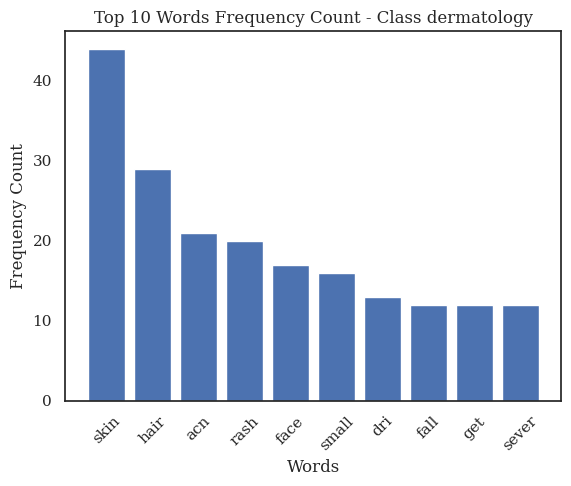

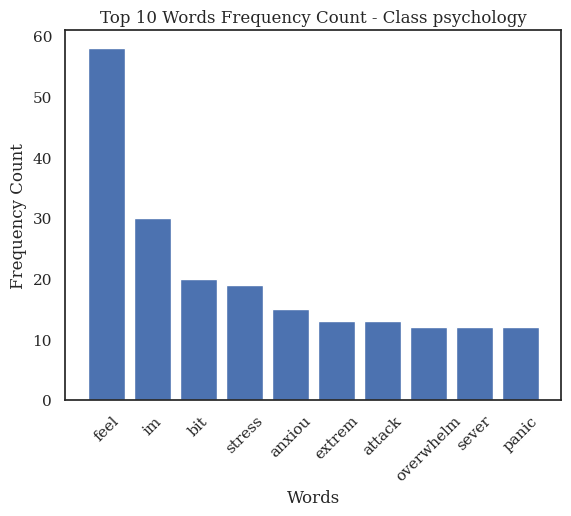

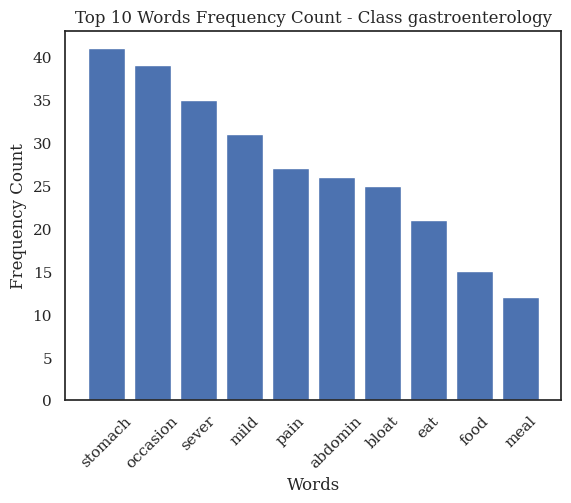

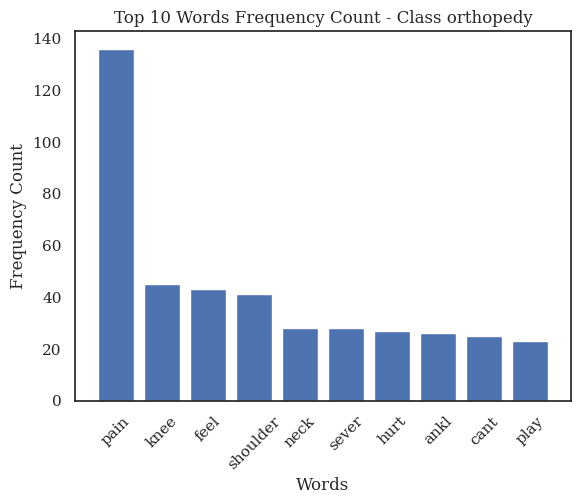

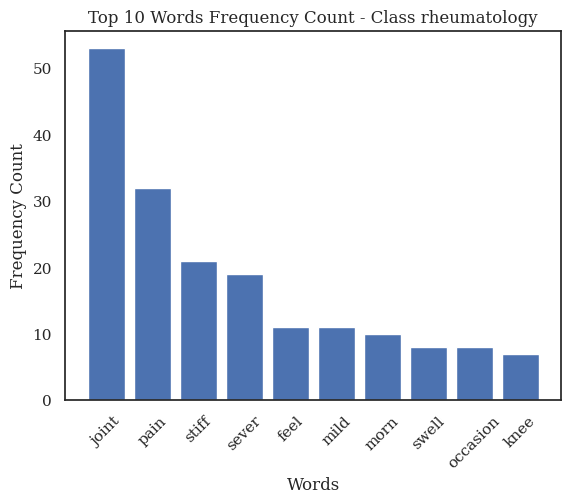

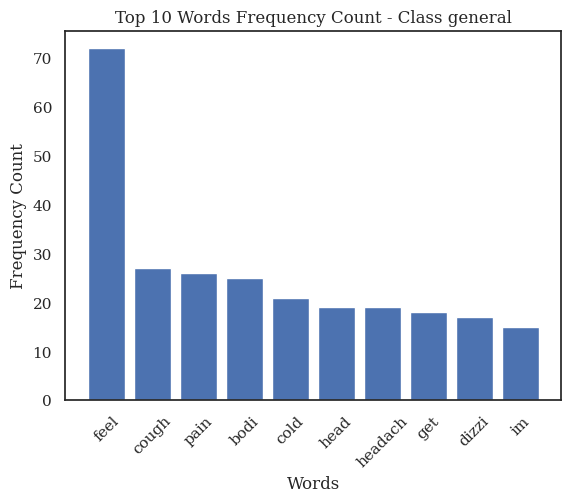

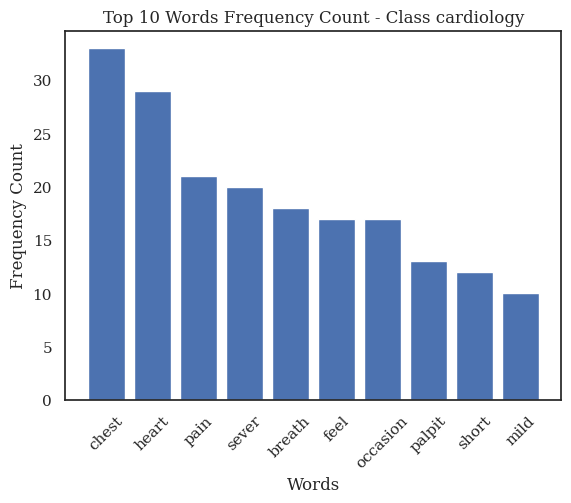

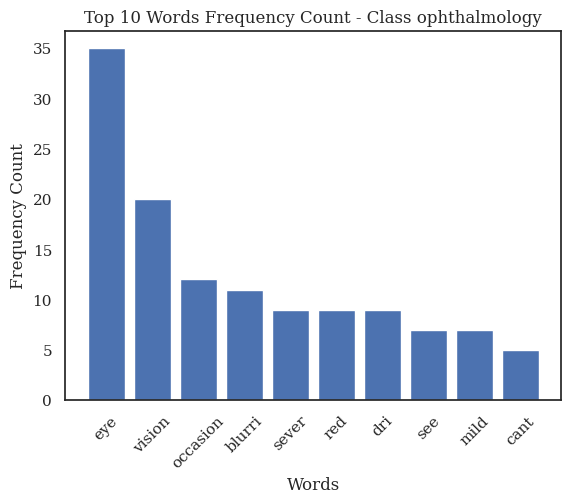

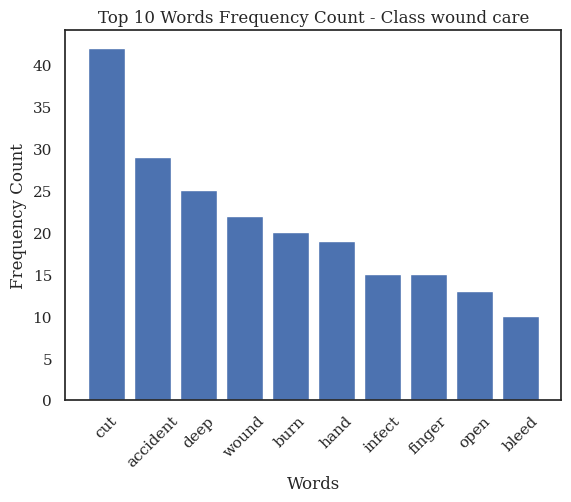

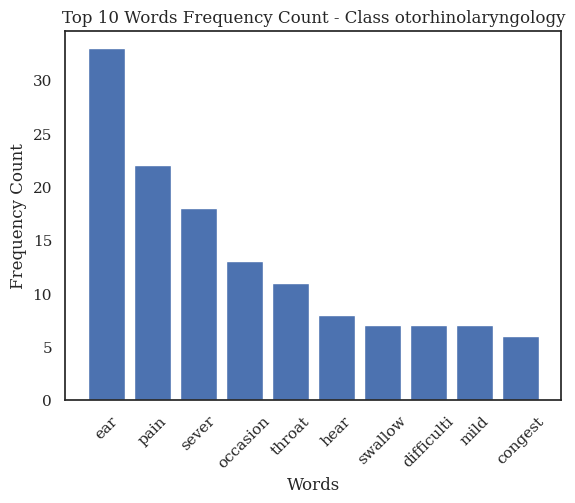

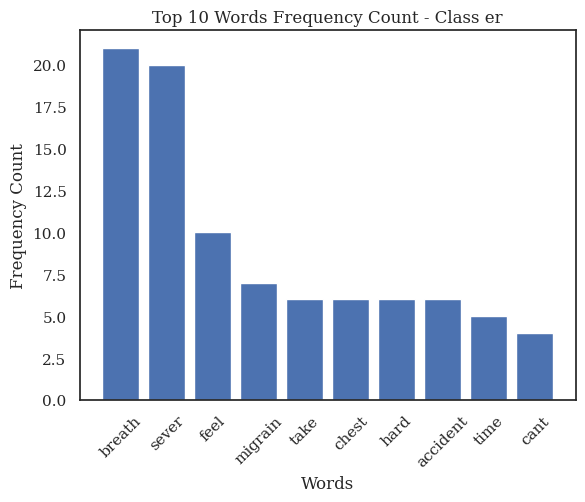

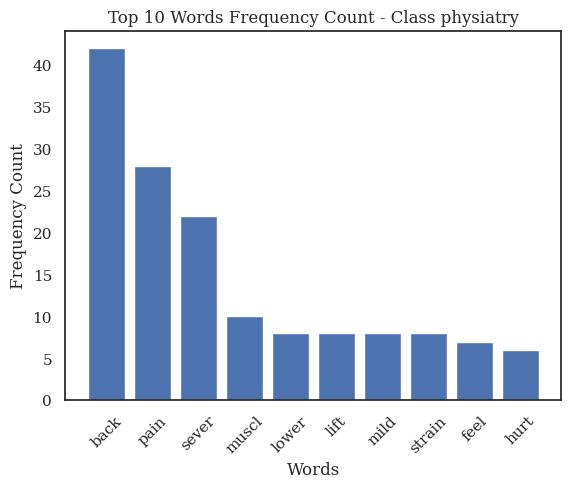

In [128]:
# identify top 10 words in each category

word_counts = Counter(' '.join(df_test2['text_clean']).split())
top_20_words = dict(word_counts.most_common(20))
print(top_20_words)

# Calculate frequency count of words per class
class_counts = {}
for cls in df_test2['prompt'].unique():
    filtered_sentences = ' '.join(df_test2[df_test2['prompt'] == cls]['text_clean'])
    word_counts = Counter(filtered_sentences.split())
    class_counts[cls] = dict(word_counts.most_common(10))

# Visualize the results for each class
for cls, word_counts in class_counts.items():
    plt.bar(word_counts.keys(), word_counts.values())
    plt.xlabel('Words')
    plt.ylabel('Frequency Count')
    plt.title(f'Top 10 Words Frequency Count - Class {cls}')
    plt.xticks(rotation=45)
    plt.show()


In [129]:
# Visalize the most common words per class by a sunburst plot

# Group the data by the "prompt" column and apply preprocessing_text to "text" column:
grouped_data = df_test2.groupby('prompt')['text_clean'].apply(lambda x: ' '.join(x)).reset_index()
grouped_data['nouns'] = grouped_data['text_clean'].apply(preprocess_text)

# Count frequency of unique nouns for each prompt and select top 10 nouns by frequency
class_noun_counts = grouped_data.explode('nouns').groupby('prompt')['nouns'].value_counts().reset_index(name='count')
top_nouns = class_noun_counts.groupby('prompt').head(10)

# Plot the Sunburst graph
fig = px.sunburst(top_nouns, path=['prompt', 'nouns'], values='count', color='count',
                  color_continuous_scale='reds', title='Top 10 nouns by specialty',
                  maxdepth=-1, branchvalues='total',
                  width=750, height=750)

fig.update_traces(textfont=dict(size=14))
fig.show()

## Multiclass text classification

In [130]:
# Create a new dataframe with two columns
df_test2 = df_test2[['prompt', 'text_clean']].copy()

# Create a new column 'category_id' with encoded categories 
df_test2['category_id'] = df_test2['prompt'].factorize()[0]
category_id_df = df_test2[['prompt', 'category_id']].drop_duplicates()

In [131]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'prompt']].values)

# New dataframe
df_test2.head()

,prompt,text_clean,category_id
0,dermatology,terribl fall hair,0
1,psychology,breakup feel someth strang,1
2,gastroenterology,eat burn sensat insid,2
3,orthopedy,play footbal muscl pain leg,3
4,orthopedy,play tenni power sensat close neck,3


In [132]:
# The text needs to be transformed to vectors so as the algorithms will be able make predictions.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df_test2.text_clean).toarray()

labels = df_test2.category_id

print("Each of the %d ailments is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1240 ailments is represented by 359 features (TF-IDF score of unigrams and bigrams)


## Multi-Classification models
The classification models evaluated are:

Random Forest
Linear Support Vector Machine
Multinomial Naive Bayes
Logistic Regression.

In [133]:
# Spliting the data into train and test sets
X = df_test2['text_clean'] # Collection of documents
y = df_test2['prompt'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df_test2.index, 
                                                                                 test_size=0.25, random_state = 0)

In [134]:
# Baseline MODEL 2
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_true = y_test.copy()
y_pred = dummy.predict(X_test)
baseline = accuracy_score(y_true, y_pred)
print(f"The baseline to beat is: {baseline}")

The baseline to beat is: 0.22258064516129034


### Accuracy

In [135]:
# Models for accuracy
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=49),
    DecisionTreeClassifier(min_samples_split=7, random_state=111)    
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [136]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
DecisionTreeClassifier,0.645968,0.083244
KNeighborsClassifier,0.701613,0.074187
LinearSVC,0.779032,0.057479
LogisticRegression,0.740323,0.094805
MultinomialNB,0.699194,0.103260
RandomForestClassifier,0.454839,0.091480


In [137]:
cv_df['col']=np.where(cv_df['model_name']=='LinearSVC', 'red', 'blue')
cv_df['model_name']=cv_df['model_name'].map({'RandomForestClassifier': 'rForest',
                                            'LinearSVC':'linSVC',
                                            'MultinomialNB': 'MulNB',
                                            'LogisticRegression':'LogRex',
                                            'KNeighborsClassifier':'KNC',
                                            'DecisionTreeClassifier':'DecTree'})


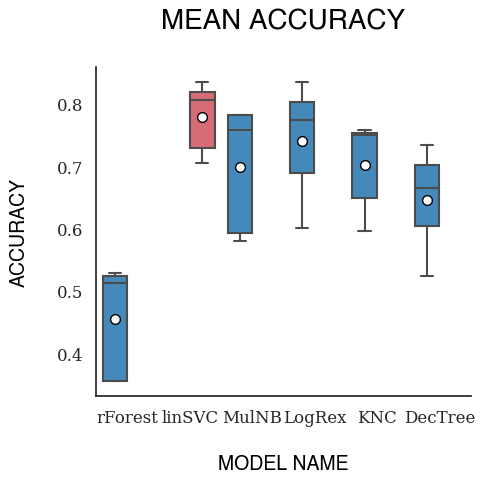

In [138]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            palette=[dark, light], 
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"7"},
           hue = 'col')
plt.title("MEAN ACCURACY\n",  fontdict= font1)
plt.xlabel("\nMODEL NAME",  fontdict= font2)
plt.ylabel("ACCURACY\n",  fontdict= font2)
plt.legend([], [], frameon=False, )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines
sns.despine()

# Adjust plot layout for better readability
plt.tight_layout()

plt.show()


In [139]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_test2.index, test_size=0.25, 
                                                               random_state=1)
model_2 = LinearSVC()
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
print(f"Recall score: {accuracy_score(y_test, y_pred)}")

Recall score: 0.8548387096774194


In [140]:
# Classification report
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df_test2['prompt'].unique()))

				CLASSIFICATION METRICS

                     precision    recall  f1-score   support

        dermatology       0.92      0.94      0.93        36
         psychology       1.00      0.83      0.91        18
   gastroenterology       0.92      0.96      0.94        23
          orthopedy       0.89      0.82      0.85        67
       rheumatology       0.93      0.81      0.87        16
            general       0.74      0.83      0.78        48
         cardiology       0.94      0.89      0.92        19
      ophthalmology       0.82      0.90      0.86        10
         wound care       0.91      0.95      0.93        21
otorhinolaryngology       0.86      0.90      0.88        21
                 er       0.65      0.61      0.63        18
          physiatry       0.71      0.77      0.74        13

           accuracy                           0.85       310
          macro avg       0.86      0.85      0.85       310
       weighted avg       0.86      0.85      0.86     

Text(0.5, 1.0, 'CONFUSION MATRIX\n')

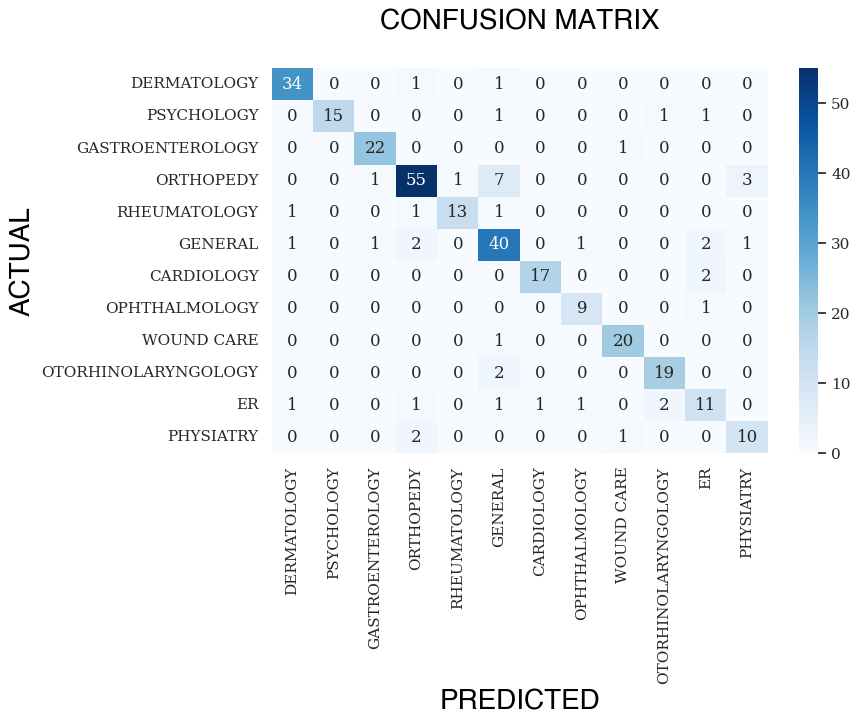

In [107]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[item.upper() for item in list(category_id_df.prompt.values)], 
            yticklabels=[item.upper() for item in list(category_id_df.prompt.values)])
plt.ylabel('ACTUAL', fontdict=font1)
plt.xlabel('PREDICTED', fontdict=font1)
plt.title("CONFUSION MATRIX\n", fontdict=font1)

In [141]:
# Misclassification
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(df_test2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['prompt', 
                                                                'text_clean']])
            print('')

'rheumatology' predicted as 'dermatology' : 1 examples.


,prompt,text_clean
6,rheumatology,bodi bad case need good treatment



'general' predicted as 'dermatology' : 1 examples.


,prompt,text_clean
620,general,drink lot get architect



'er' predicted as 'dermatology' : 1 examples.


,prompt,text_clean
725,er,sever tooth infect face swollen



'orthopedy' predicted as 'gastroenterology' : 1 examples.


,prompt,text_clean
262,orthopedy,pain cramp feet



'general' predicted as 'gastroenterology' : 1 examples.


,prompt,text_clean
258,general,pain stomach



'dermatology' predicted as 'orthopedy' : 1 examples.


,prompt,text_clean
301,dermatology,found issu skin tri use cream get better



'rheumatology' predicted as 'orthopedy' : 1 examples.


,prompt,text_clean
99,rheumatology,feel click sensat knee time step



'general' predicted as 'orthopedy' : 2 examples.


,prompt,text_clean
120,general,feel like ice cube sister said need
41,general,run nose



'er' predicted as 'orthopedy' : 1 examples.


,prompt,text_clean
1118,er,fell hit head experienc dizzi



'physiatry' predicted as 'orthopedy' : 2 examples.


,prompt,text_clean
553,physiatry,upper back sore week
636,physiatry,play sport burn sensat spine



'orthopedy' predicted as 'rheumatology' : 1 examples.


,prompt,text_clean
520,orthopedy,neck feel stiff



'dermatology' predicted as 'general' : 1 examples.


,prompt,text_clean
201,dermatology,get cluster whitehead blackhead back



'psychology' predicted as 'general' : 1 examples.


,prompt,text_clean
639,psychology,rememb feel



'orthopedy' predicted as 'general' : 7 examples.


,prompt,text_clean
259,orthopedy,pain trap
575,orthopedy,arch feet hurt wear heel
239,orthopedy,foot ach winter feel cold
382,orthopedy,activ sport bodi feel pain
599,orthopedy,daddi sharp pain scalp
597,orthopedy,sharp pain bicep
571,orthopedy,stiff inabl look right left except move whole...



'rheumatology' predicted as 'general' : 1 examples.


,prompt,text_clean
236,rheumatology,feel like whole bodi complain



'wound care' predicted as 'general' : 1 examples.


,prompt,text_clean
283,wound care,bond toe get better overnight reopen everi da...



'otorhinolaryngology' predicted as 'general' : 2 examples.


,prompt,text_clean
640,otorhinolaryngology,sneez hard feel earach
288,otorhinolaryngology,earach shower



'er' predicted as 'general' : 1 examples.


,prompt,text_clean
680,er,persist cough blood phlegm



'er' predicted as 'cardiology' : 1 examples.


,prompt,text_clean
372,er,walk everyday get short breath go short way



'general' predicted as 'ophthalmology' : 1 examples.


,prompt,text_clean
94,general,dont energi thing use



'er' predicted as 'ophthalmology' : 1 examples.


,prompt,text_clean
593,er,dark time see crust



'gastroenterology' predicted as 'wound care' : 1 examples.


,prompt,text_clean
311,gastroenterology,colon stomach like someth cut



'physiatry' predicted as 'wound care' : 1 examples.


,prompt,text_clean
422,physiatry,longitudin burn line across back hard respira...



'psychology' predicted as 'otorhinolaryngology' : 1 examples.


,prompt,text_clean
205,psychology,got divorc last year cant stop dwell get reve...



'er' predicted as 'otorhinolaryngology' : 2 examples.


,prompt,text_clean
525,er,nose congest time there gluey secret throat m...
267,er,problem expir bronchial asthma



'psychology' predicted as 'er' : 1 examples.


,prompt,text_clean
35,psychology,heavi breath fatigu



'general' predicted as 'er' : 2 examples.


,prompt,text_clean
204,general,get tire fast bare put cloth morn
323,general,terribl problem im breath night



'cardiology' predicted as 'er' : 2 examples.


,prompt,text_clean
935,cardiology,sever chest tight difficulti breath
877,cardiology,sever chest tight difficulti breath



'ophthalmology' predicted as 'er' : 1 examples.


,prompt,text_clean
757,ophthalmology,accident got chemic splash eye



'orthopedy' predicted as 'physiatry' : 3 examples.


,prompt,text_clean
699,orthopedy,experienc sever back pain
8,orthopedy,annoy start suddenli often injuri exercis
675,orthopedy,sharp stab pain lower back



'general' predicted as 'physiatry' : 1 examples.


,prompt,text_clean
481,general,headach sinc woke morn


In [142]:
# Most correlated terms with each category
model_2.fit(features, labels)

n = 4
for prompt, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model_2.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:n]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:n]
    print("\n==> '{}':".format(prompt))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'cardiology':
  * Top unigrams: heart, chest, palpit, left
  * Top bigrams: pain chest, short breath, occasion feel, heart hurt

==> 'dermatology':
  * Top unigrams: hair, acn, skin, rash
  * Top bigrams: sever skin, hair fall, wont away, lot hair

==> 'er':
  * Top unigrams: breath, accident, migrain, time
  * Top bigrams: sever migrain, sever allerg, sometim feel, like someth

==> 'gastroenterology':
  * Top unigrams: stomach, indigest, heartburn, abdomin
  * Top bigrams: stomach ach, abdomin pain, occasion bloat, sever abdomin

==> 'general':
  * Top unigrams: cough, weak, headach, head
  * Top bigrams: feel dizzi, head hurt, pain head, feel cold

==> 'ophthalmology':
  * Top unigrams: eye, vision, glass, blurri
  * Top bigrams: mild eye, dri eye, sever eye, blurri vision

==> 'orthopedy':
  * Top unigrams: wrist, neck, knee, shoulder
  * Top bigrams: muscl pain, knee pain, pain neck, shoulder pain

==> 'otorhinolaryngology':
  * Top unigrams: ear, hear, congest, pressur
  * To

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



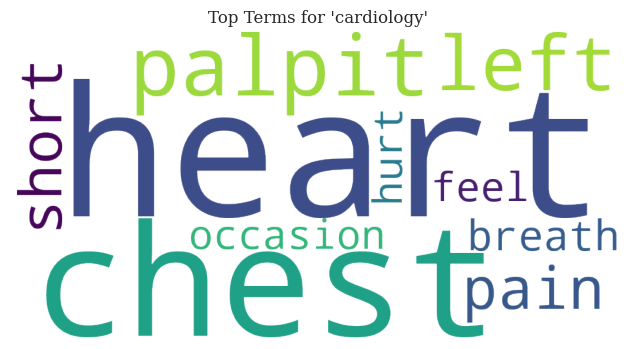

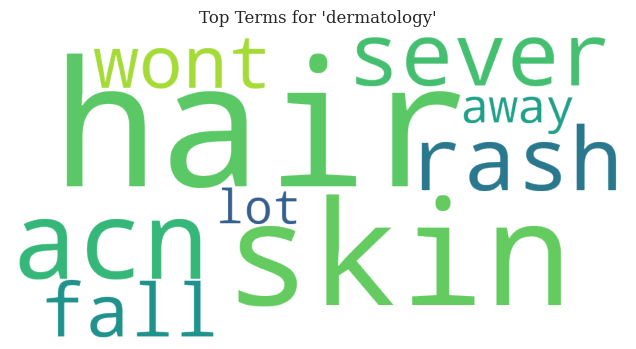

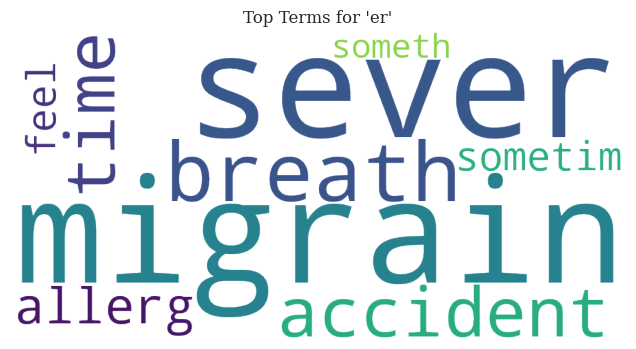

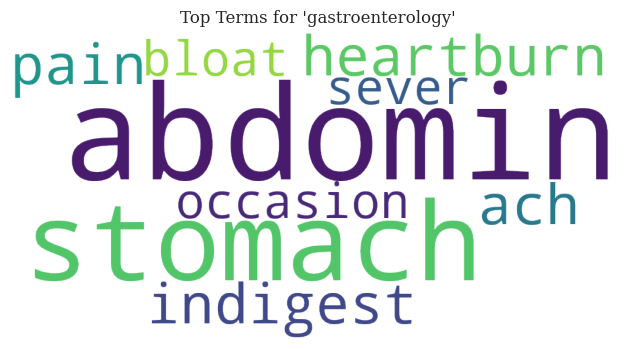

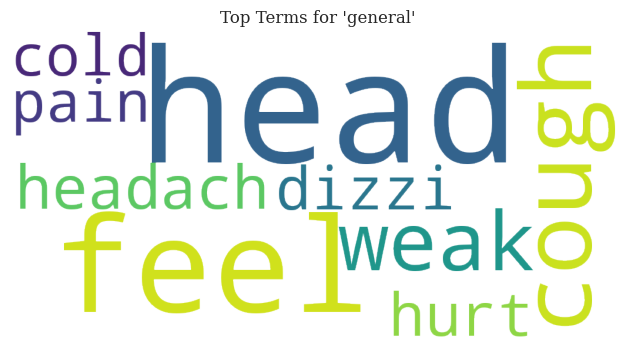

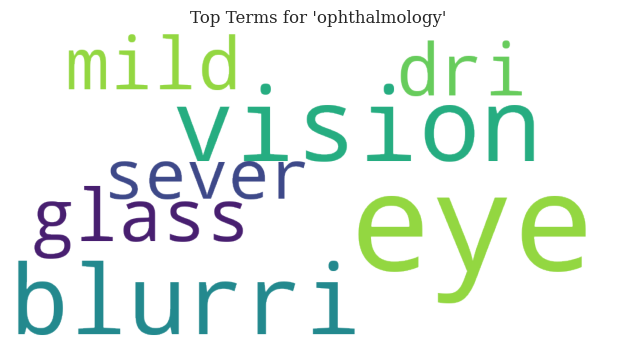

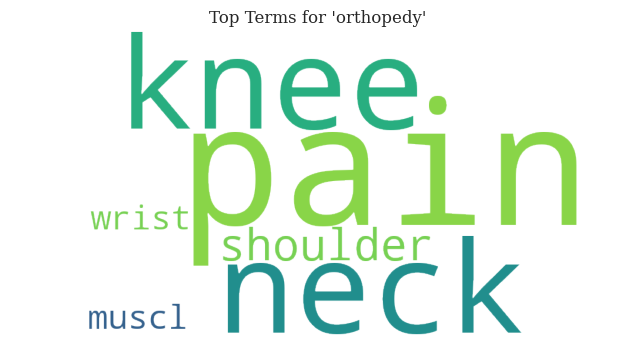

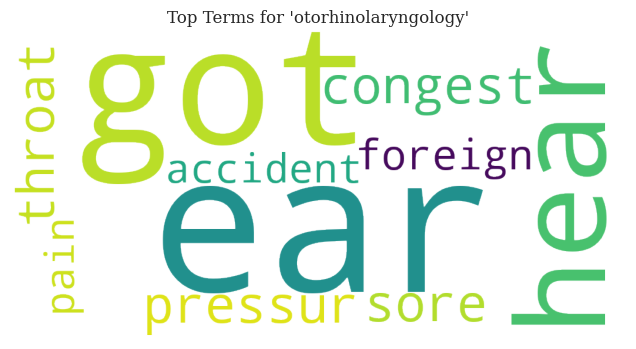

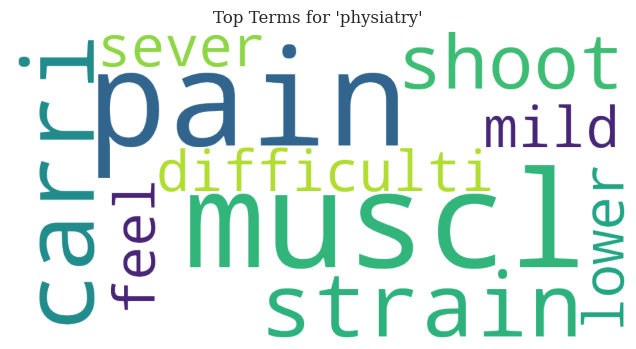

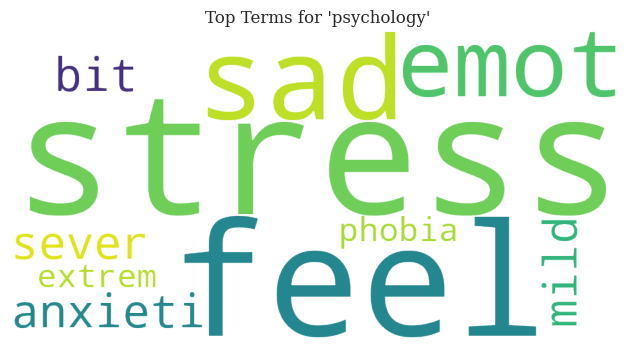

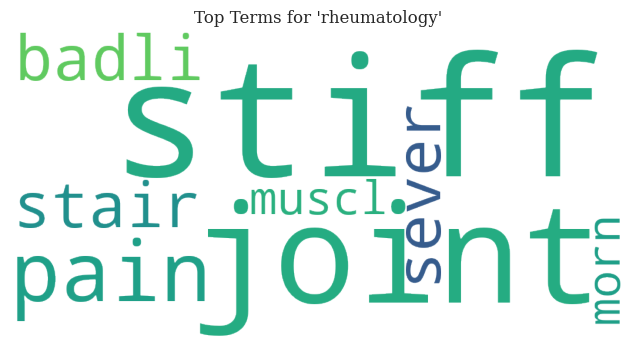

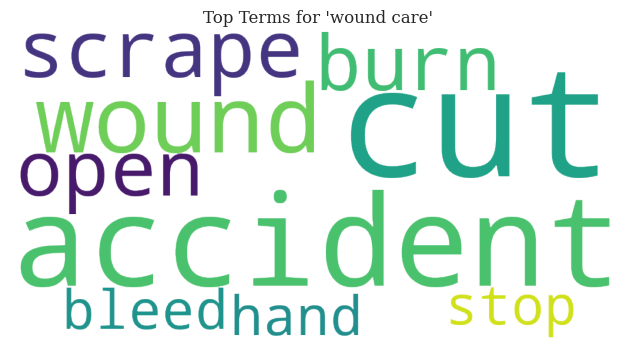

In [110]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create word clouds for each prompt
for prompt, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model_2.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:4]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:4]
    
    # Combine unigrams and bigrams into a single list
    top_terms = unigrams + bigrams
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='rgba(255, 255, 255, 0)', mode='RGBA').generate(' '.join(top_terms))
    
    # Plot the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Top Terms for '{}'".format(prompt))
    plt.axis('off')
    
    # Save the word cloud as PNG with transparent background
    #wordcloud.to_file('wordcloud_{}.png'.format(prompt.replace(" ", "_")))
    
    plt.show()


In [146]:
# Save model_1 in a pipeline and export it with pickle

import pickle
from sklearn.pipeline import Pipeline

tf_vect = TfidfVectorizer()
clf = LinearSVC()
pipe = Pipeline([("vectorizer", tf_vect), ("classifier", clf)])
pipe.fit(X, y)


with open('model_2', 'wb') as picklefile:
    pickle.dump(pipe, picklefile)

In [1]:
### Text Model_2 on never seen before sentence!

fitted_vectorizer = tfidf.fit(X)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X)

model__2 = LinearSVC().fit(tfidf_vectorizer_vectors, y)

text_input = stemmer(text_process(do_clean("When I play footbal I fell muscle pain in the right leg.")))
print(model__2.predict(fitted_vectorizer.transform([text_input])))

NameError: name 'tfidf' is not defined

# Real-time audio from user 

In [29]:
#pip install pyaudio

  Using cached PyAudio-0.2.13.tar.gz (46 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyaudio: filename=PyAudio-0.2.13-cp39-cp39-macosx_10_9_x86_64.whl size=24156 sha256=16663ce607b42b26b3b62f30e62260d539edba4f46ab255d3f923af4013ea308
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/d5/52/ae/fa7c92aa6e9f30fc009f4f5d7caf459fad3610f0a4022cf12a
Successfully built pyaudio
Note: you may need to restart the kernel to use updated packages.


In [71]:
# identify the index of the devide (microphone) to use

import pyaudio

p = pyaudio.PyAudio()

for i in range(p.get_device_count()):
    print(p.get_device_info_by_index(i))
    
p.terminate()

# the index to use is 0

{'index': 0, 'structVersion': 2, 'name': 'Built-in Microphone', 'hostApi': 0, 'maxInputChannels': 2, 'maxOutputChannels': 0, 'defaultLowInputLatency': 0.0029478458049886623, 'defaultLowOutputLatency': 0.01, 'defaultHighInputLatency': 0.01310657596371882, 'defaultHighOutputLatency': 0.1, 'defaultSampleRate': 44100.0}
{'index': 1, 'structVersion': 2, 'name': 'Built-in Output', 'hostApi': 0, 'maxInputChannels': 0, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038775510204081634, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.014036281179138322, 'defaultSampleRate': 44100.0}


In [117]:
CHANNEL = 1
FRAME_RATE = 16000
RECORD_SECONDS = 2
AUDIO_FORMAT = pyaudio.paInt16
SAMPLE_SIZE = 2

def record_microphone(chunk = 1024): # how often we are going to read from the microphone
    """Record microphone audio."""
    p = pyaudio.PyAudio()
    
    stream = p.open(format = AUDIO_FORMAT,
                   channels = CHANNEL,
                   rate = FRAME_RATE,
                   input = True,
                   input_device_index = 0,
                   frames_per_buffer = chunk)
    
    frames = []
    
    while not messages.empty():
        data = stream.read(chunk)
        frames.append(data)
        
        # every tot seconds specified by RECORD_SECONDS we pass our audio data
        # that has been recorded to our transcription engine and then it starts 
        # recording another tot seconds of audio, untill we tell to stop recording.
        if len(frames) >= (FRAME_RATE * RECORD_SECONDS) / chunk:
            recordings.put(frames.copy())
            frame = []
            
    # Once we have pressed the Stop button
    stream.stop_stream()
    stream.close()
    p.terminate()
    


In [115]:
# !pip install vosk
# !pip install transformers
# !pip install torch
import subprocess
import json
from vosk import Model,KaldiRecognizer
import time

model = Model(model_name = "vosk-model-en-us-0.22")
rec = KaldiRecognizer(model, FRAME_RATE)
rec.SetWords(True)

def speech_recognition(output):
    """Transcribe audio into text"""
    while not messages.empty():
        frames = recordings.get()
        
        rec.AcceptWaveform(b''.join(frames))
        result = rec.Result()
        text = json.loads(result)["text"]
        
        # Add puntuation to the text
        #cased = subprocess.check_output('python recasepunc/recasepunc.py predict recasepunc/checkpoint', shell=True, text=True, input=text)

        #output.append_stdout(cased)
        time.sleep(1)

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:11:12:13:14:15
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /Users/admin/.cache/vosk/vosk-model-en-us-0.22/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /Users/admin/.cache/vosk/vosk-model-en-us-0.22/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:294) Loading words from /Users/admin/.cache/vosk/vosk-model-en-us-0.22/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo /Users/admin/.cache/vosk/vosk-model-en

In [118]:
#source: https://www.youtube.com/watch?v=2kSPbH4jWME

import ipywidgets as widgets
from IPython.display import display
from threading import Thread #threads are functions that run in the background without interrupting the code
from queue import Queue #it allows to pass messages between threads

messages = Queue() # it will tell the thread when to recording and when to stop transcribing
recordings = Queue() # it stores audio, and it passes it to the transcription

# Make `Record` button
record_button = widgets.Button(description = "Record",
                              disabled = False,
                              button_style = "success",
                              icon = "microphone")
# Make `Stop` button
stop_button = widgets.Button(description = "Stop",
                              disabled = False,
                              button_style = "warning",
                              icon = "stop")
# output 
output = widgets.Output()

# Defining 2 functions: one for start recording and one for stopping recording
def start_recording(data):
    """ It gives a message to 'messages'queue and that message is going to
    tell these threds to keep running. It then creats to threds and run them
    in teh background: one to record the microphone audio and one to transcribe
    it into text. """
    messages.put(True) # it put a message to the queue
    
    with output:
        display("Recording...") # it displayes Recording... as message in the outer widget
        record = Thread(target=record_microphone) # creating a threads that records the microphone
        record.start() # starts the threads and have it running in the background
        
        transcribe = Thread(target=speech_recognition, args=(output,))
        transcribe.start()
        
        
def stop_recording(data):
    with output:
        messages.get() # it takes the massage off the queue
        display("Stopped.")
        
        

record_button.on_click(start_recording)
stop_button.on_click(stop_recording)

display(record_button, stop_button, output)

Button(button_style='success', description='Record', icon='microphone', style=ButtonStyle())

Button(button_style='warning', description='Stop', icon='stop', style=ButtonStyle())

Output()